# HarvestStat Data Profiling - Afghanistan

In [3]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [4]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32642' # Afghanistan
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/AF_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
#PrintAdminUnits(shape_all)
# ----------------------------------------------- #
# Log in to get access to "_Alt" source docs that extend the time series
auth = tuple(json.loads(open('token.json', "r").read()))

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={},auth=auth)
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([AF_Admin1_2005, AF_Admin1_2017], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

../figures/AF_admin_shapes.png is saved.


In [5]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_AF.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_AF.csv is saved.


In [6]:
# ------------------------------------------------------------------------------- #
#  Process the difference between the "Alt" time series and the regular time series
#  Add entries from the "Alt" series to the full series if they're missing
# ------------------------------------------------------------------------------- #

#Split into an "Alt" DF and a regular DF
dfAlt = df.loc[df.source_document.str[:3]=='Alt',:]
df = df.loc[df.source_document.str[:3]!='Alt',:]

i = 0
for ipr in dfAlt['product'].unique():
    for icp in dfAlt.crop_production_system.unique():
        #Limit the Alt time series to dates not in the full dataset
        altStrts = dfAlt.start_date.unique()[~(
            np.isin(dfAlt.loc[(dfAlt['product']==ipr)&(dfAlt.crop_production_system==icp),'start_date'].unique(),
                     df.loc[(df['product']==ipr)&(df.crop_production_system==icp),'start_date'].unique())
                            )]
        idfAlt = dfAlt.loc[np.isin(dfAlt.start_date.values,altStrts)&
                (dfAlt['product']==ipr)&(dfAlt.crop_production_system==icp),:]

        #track alt DF entries to add to the full df
        if i==0:
            dfAltAdd = idfAlt
            i+=1
        else:
            dfAltAdd = pd.concat([dfAltAdd,idfAlt])
#merge the Alt dates not in the regular df back into the df
df = pd.concat([df,dfAltAdd])

In [7]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 24,196
Removed 8,975 "Missing Value" points
0/6,049 "Area Harvested" points are retained.
5,116/6,049 "Area Planted" points are retained.
5,053/6,049 "Quantity Produced" points are retained.
5,052/6,049 "Yield" points are retained.
Current data points: 15,221

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 2002 - 2022
12 grain types are found: Almond (unspecified), Apple (unspecified), Barley (Unspecified), Cotton (Unspecified), Grape (unspecified), Maize (Corn), Peach (unspecified), Pomegranate, Rice (Paddy), Saffron, Soybean (unspecified), Wheat Grain
1 seasons are found: Annual (07-01)
3 crop production system are found: irrigated, All (PS), Rainfed (PS)
Data sources include:
[1] MAIL, Afghanistan --- Official agricultural statistics, Afghanistan, crop
[2] MAIL, Afghanistan --- Alt_Official agricultural statistics, Afghanistan, crop
Administrativ

In [8]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = AF_Admin1_2005.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
shape_used['ADMIN2'] = 'None'
shape_all['ADMIN2'] = 'None'
shape_latest['ADMIN2'] = 'None'
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

- Afghanistan crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-afghanistan.png?itok=syYg1jn1"  width=900><br>

<img src="https://ipad.fas.usda.gov/countrysummary/images/AF/cropcalendar/stans_af_calendar.png"  width=900><br>

<img src="../figures/crop_calendar/Afghanistan_-_Crop_calendar.jpg"  width=900><br>

- FDW data consists of `AF2005A1` and `AF2017A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 2000	 | AF2000A1 | 32	| AF2000A2	| 330	|
| 2005	 | AF2005A1 | 34	| - | 0	| nan	|
| 2013	 | AF2013A1 | 34	| AF2013A2	| 399	|
| 2017	 | **`AF2017A1`** | 34	| AF2017A2	| 401	|

- Comparison between admin boundaries.

<img src="../figures/AF_admin_shapes.png"  width=900>

- **`AF2017A1`** is used to represent current admin-level 1 crop data.
- Afghanistan has 3 crop seasons: `Spring (07-01)`, `Summer (08-01)` and `Winter (11-01)`.
- Afghanistan has no crop production system.
- Afghanistan has no population group.

In [10]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_AF.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_AF.csv is saved.


# Visualization of production data

/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


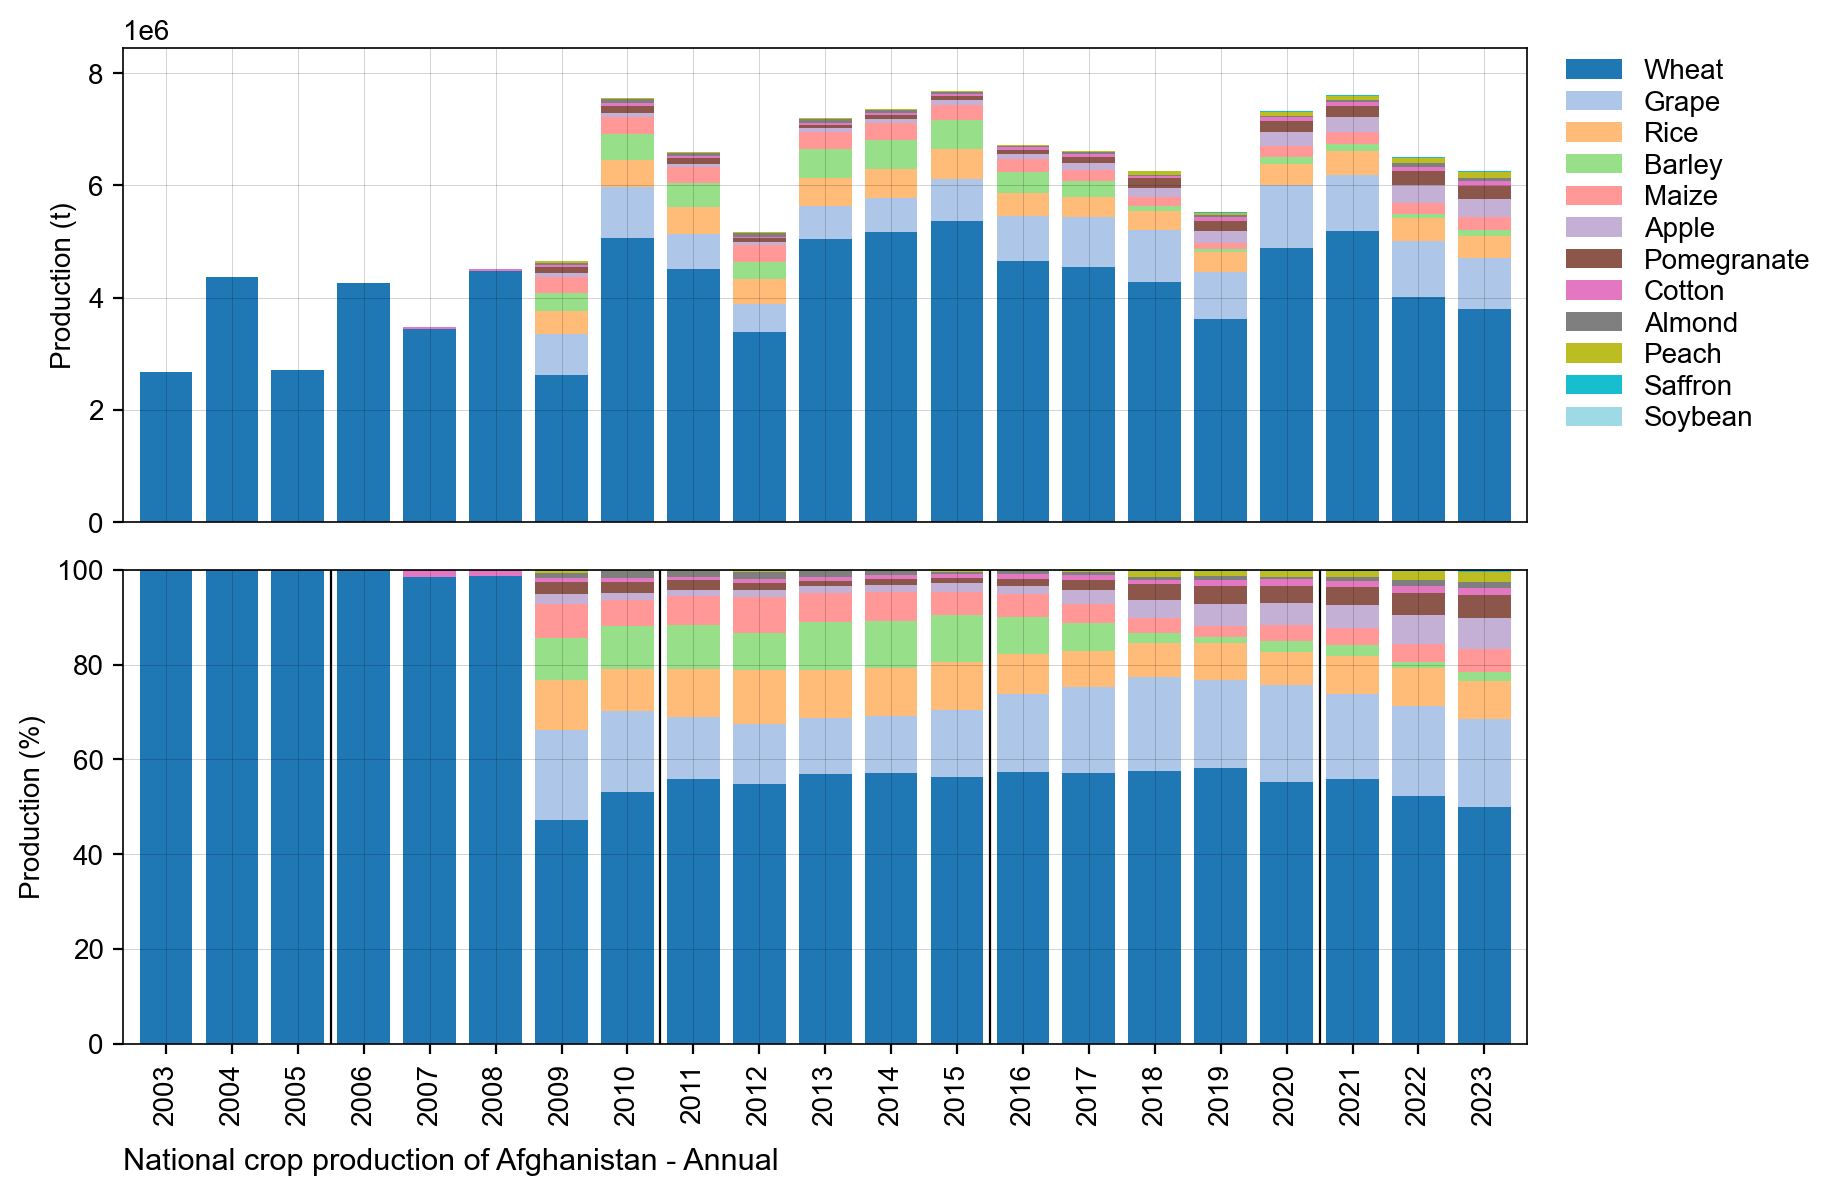

../figures/AF_bar_natgrainprod_Annual.png is saved.


In [32]:
# Bar chart of national crop production
country_iso, country_name = 'AF', 'Afghanistan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

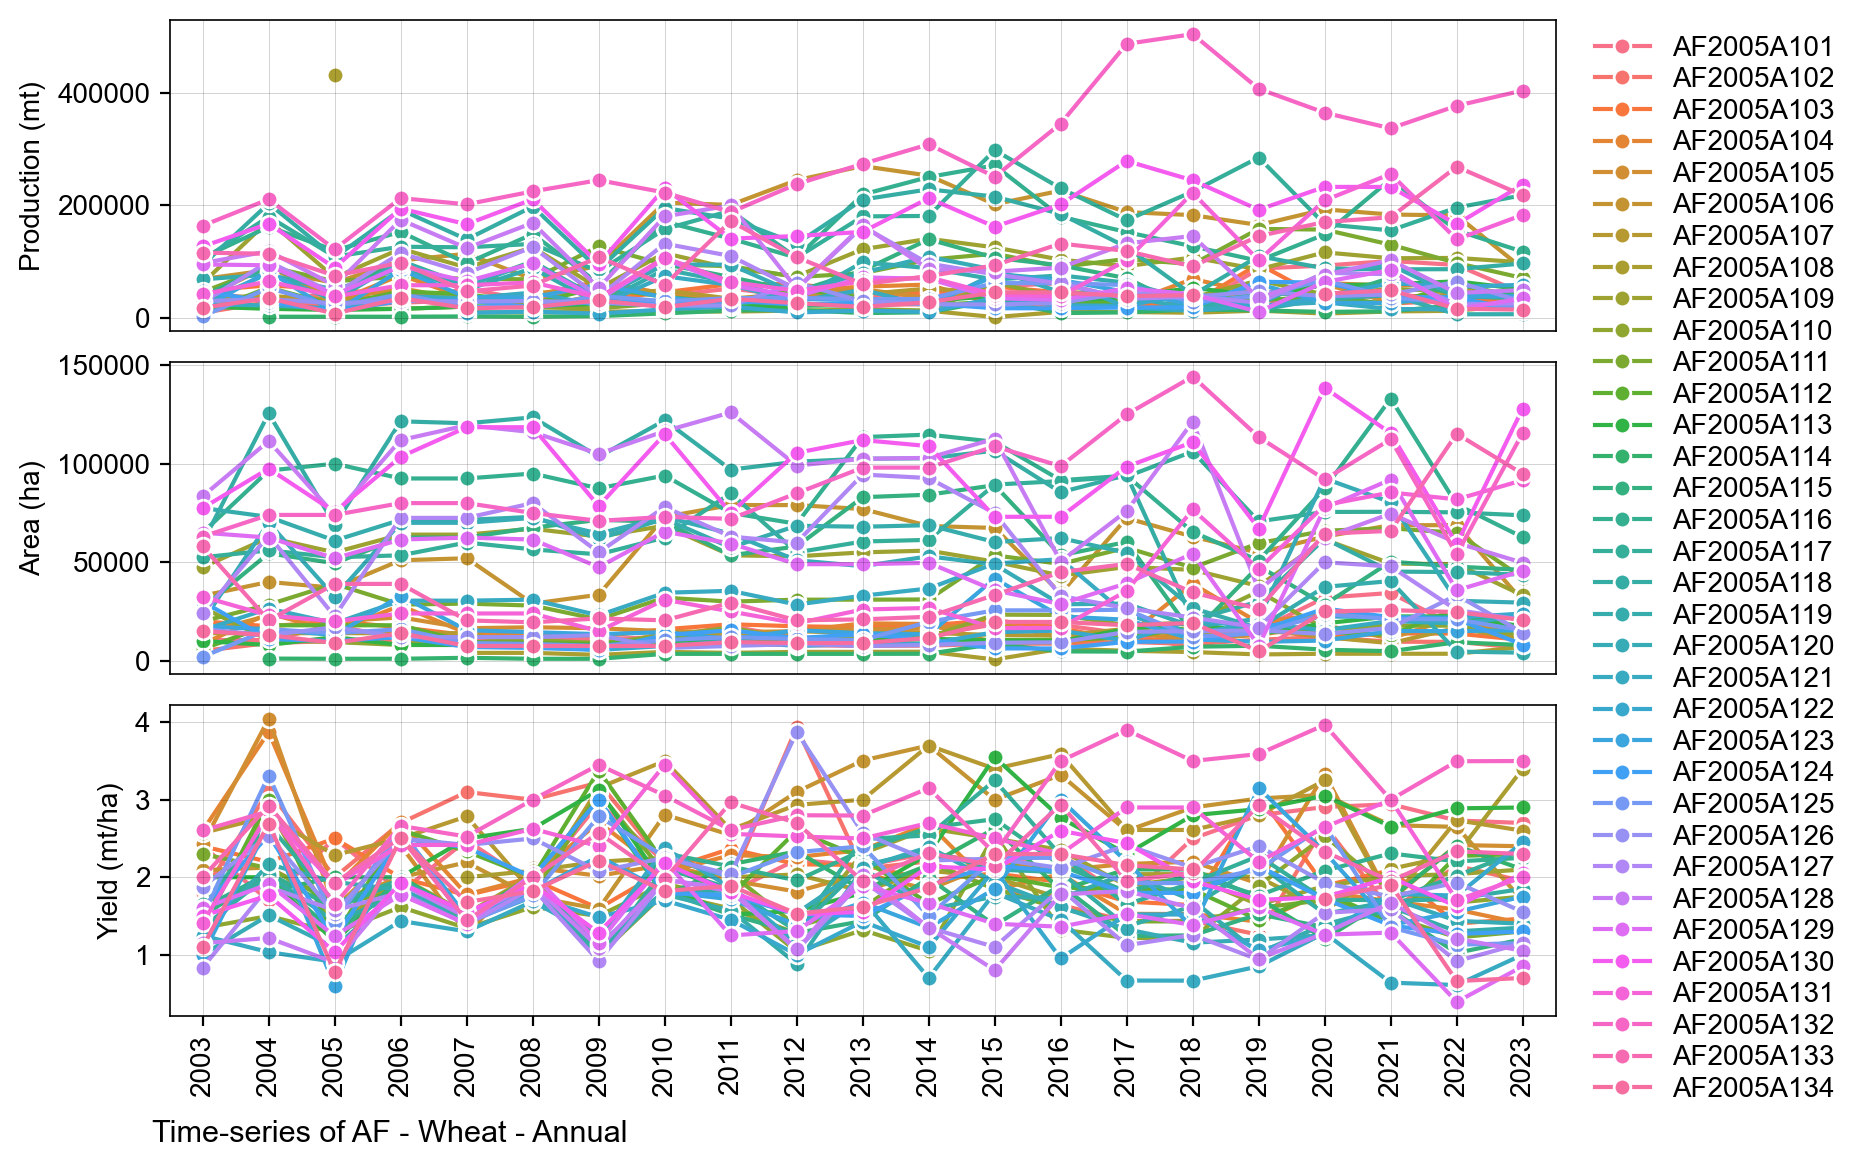

In [37]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'AF', 'Afghanistan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Wheat','Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)